In [1]:
import pandas as pd
import psycopg2 as pg
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import confusion_matrix,matthews_corrcoef,accuracy_score
import optuna
import pickle
from sklearn.feature_selection import SequentialFeatureSelector
reload_data = True
def norm(x):
    if len(x)==1 and x[0]=='':
        return []
    else:
        return x
if reload_data:
    engine = pg.connect("dbname='safeidx' user='fbk_mpba' host='172.104.247.67' port='5432' password='fbk2024$'")
    df = pd.read_sql('select * from fbk_export_20240212', con=engine) 
    with open('data.pkl','wb') as f:
        pickle.dump(df,f)
else:
    with open('data.pkl','rb') as f:
        df = pickle.load(f)


/tmp/ipykernel_69977/3424305685.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/home/agobbi/miniconda3/envs/pid/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_69977/3424305685.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read

In [2]:
## these columns can lead to overfit!
df.drop(columns=['dateandtime','skiarea_id','day_of_year','minute_of_day','year'], inplace=True)

In [3]:
df

skiarea_name  season    difficulty             cause  \
0                     Pampeago    2009        novice        fall_alone   
1                     Pampeago    2009      advanced        fall_alone   
2                     Pampeago    2009      advanced        fall_alone   
3                     Pampeago    2009      advanced  collision_person   
4                     Pampeago    2009      advanced  collision_person   
...                        ...     ...           ...               ...   
150102              Speikboden    2024  intermediate        fall_alone   
150103            Bardonecchia    2024          easy        fall_alone   
150104               Klausberg    2024          easy  collision_person   
150105             Moena Lusia    2024  intermediate        fall_alone   
150106  Porta Vescovo - Arabba    2024  intermediate        fall_alone   

                                           town province gender equipment  \
0                                        SIKLOS               F       ski   
1                                         MALMO               M       ski   
2                                       CALDARO       BZ      F       ski   
3                                          LINZ               M       ski   
4                                        RUSAVA               M       ski   
...                                         ...      ...    ...       ...   
150102  Dettmannsdorf OT Dettmannsdorf - Kölzow     None      F       ski   
150103                                   Milano   Milano      M       ski   
150104                               Düsseldorf     None      F       ski   
150105                                   Rimini   Rimini      F       ski   
150106                            Busto Garolfo   Milano      F       ski   

       helmet              destination   diagnosis india   age  \
0        None  hospital_emergency_room  distortion  None  32.0   
1        None  hospital_emergency_room      bruise  None  32.0   
2        None                 domicile       other  None  12.0   
3        None  hospital_emergency_room      bruise  None  58.0   
4        None                    other      bruise  None  25.0   
...       ...                      ...         ...   ...   ...   
150102   True  hospital_emergency_room       other    i2  37.0   
150103   True                     None       wound  None  33.0   
150104   True             traumacenter       other    i2  66.0   
150105   True                 domicile      bruise  None  14.0   
150106   True                 domicile  distortion  None  58.0   

                country injury_side injury_general_location  \
0              Ungheria           L             lower_limbs   
1                Svezia           R           skull_or_face   
2                Italia           R                    None   
3               Austria           R             lower_limbs   
4       Repubblica Ceca           L             lower_limbs   
...                 ...         ...                     ...   
150102         Germania           L             lower_limbs   
150103           Italia           L             upper_limbs   
150104         Germania           L             upper_limbs   
150105           Italia           R             lower_limbs   
150106           Italia           L             lower_limbs   

                  evacuation_vehicles  
0                              [akja]  
1                              [akja]  
2                        [snowmobile]  
3                        [snowmobile]  
4                             [other]  
...                               ...  
150102  [snowmobile_sled, helicopter]  
150103                [indipendently]  
150104    [car, ski_lift, snowmobile]  
150105         [ski_lift, snowmobile]  
150106                         [akja]  

[150107 rows x 17 columns]

In [4]:
##evacuation_vehicles must be explicitated
ev = set({})
for i,row in df.iterrows():
    ev = ev.union(set(row.evacuation_vehicles))
for c in ev:
    df[c] = False
for i,row in df.iterrows():
    for c in row.evacuation_vehicles:
        df.loc[i,c] = True
df.drop(columns=['town','province','evacuation_vehicles'],inplace=True)



In [5]:
df.columns

Index(['skiarea_name', 'season', 'difficulty', 'cause', 'gender', 'equipment',
       'helmet', 'destination', 'diagnosis', 'india', 'age', 'country',
       'injury_side', 'injury_general_location', 'snowmobile_sled', 'car',
       'ski_lift', 'ambulance', 'privat_helicopter', 'skiarea_ambulance',
       'snowmobile', 'quad', 'helicopter', 'akja', 'offroad_vehicle', 'other',
       'indipendently'],
      dtype='object')

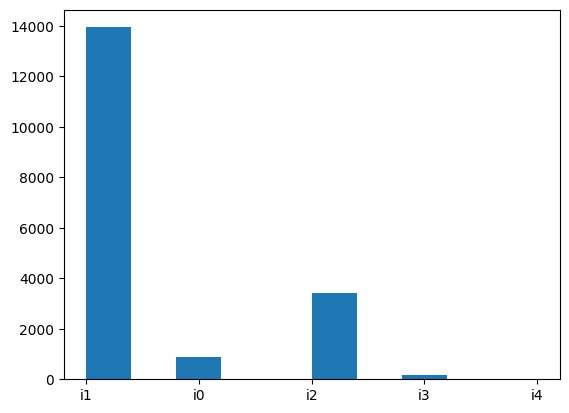

In [6]:
#plot india distribution
labeled = df[~pd.isna(df.india)].reset_index().drop(columns='index')
labeled['age'] =  labeled['age'].astype(np.float32).fillna(np.nan)
plt.hist(labeled.india);

In [54]:
labeled.head()

skiarea_name  season    difficulty       cause gender equipment helmet  \
0    Kronplatz    2018          None  fall_alone      F       ski   True   
1    Kronplatz    2018          easy     illness      M       ski   True   
2    Kronplatz    2018      advanced  fall_alone      M       ski   True   
3    Kronplatz    2018      advanced  fall_alone      M       ski   True   
4    Kronplatz    2018  intermediate  fall_alone      M       ski   True   

               destination   diagnosis  india  ...  ambulance  \
0  hospital_emergency_room  distortion      1  ...      False   
1                 domicile       other      0  ...      False   
2  hospital_emergency_room       wound      1  ...      False   
3  hospital_emergency_room    fracture      1  ...      False   
4  hospital_emergency_room       other      1  ...      False   

  privat_helicopter skiarea_ambulance snowmobile   quad helicopter   akja  \
0             False             False       True  False      False  False   
1             False             False      False  False      False  False   
2             False             False      False  False      False   True   
3             False             False      False  False      False   True   
4             False             False      False  False      False   True   

  offroad_vehicle  other indipendently  
0           False  False         False  
1           False  False         False  
2           False  False         False  
3           False  False         False  
4           False  False         False  

[5 rows x 27 columns]

/tmp/ipykernel_69977/944685202.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


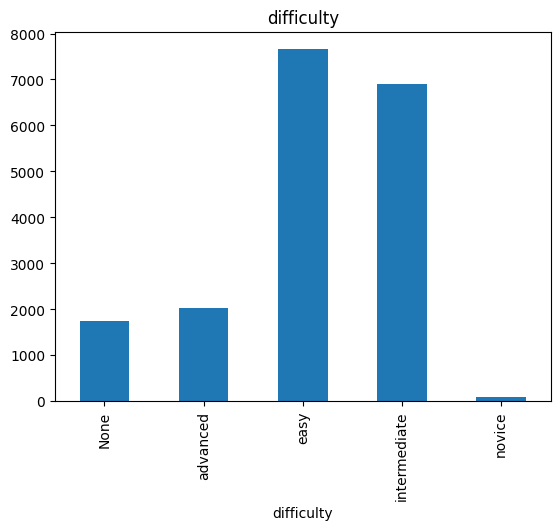

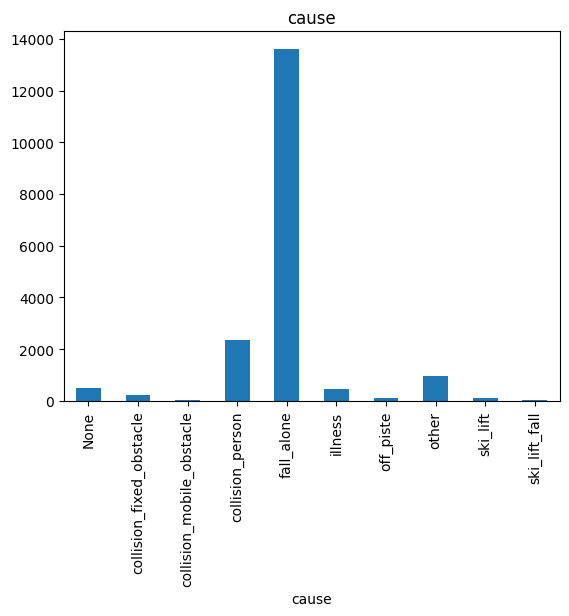

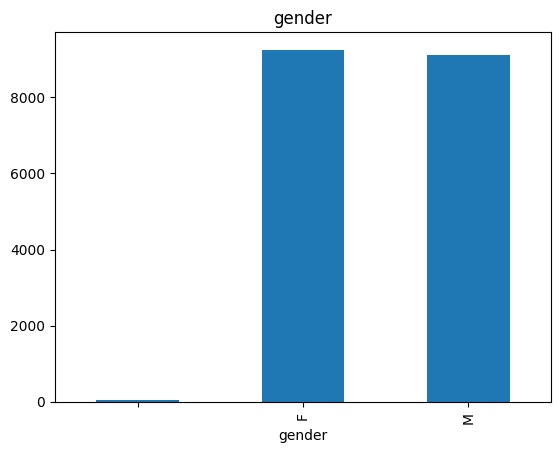

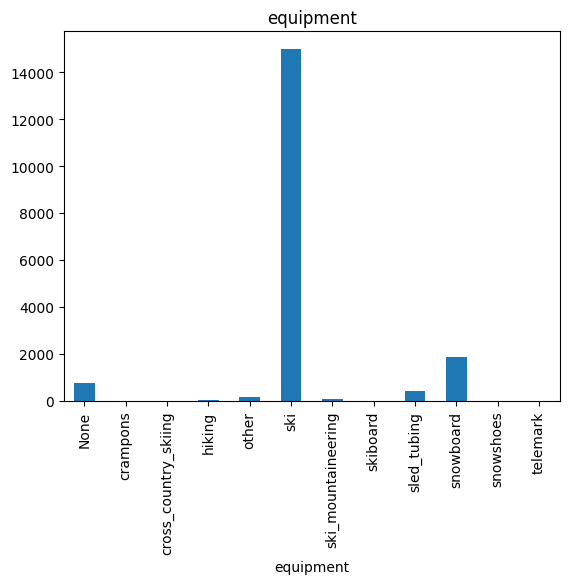

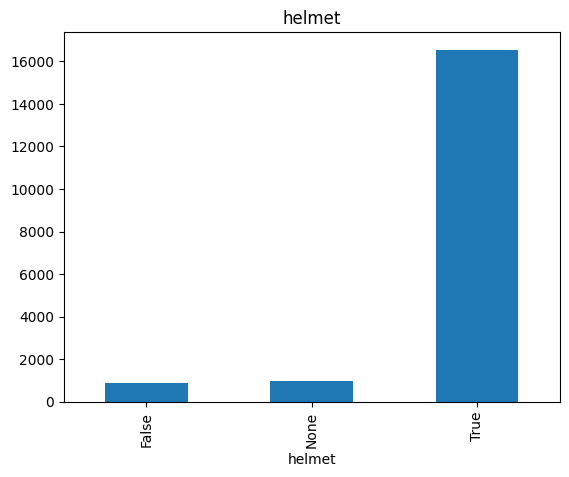

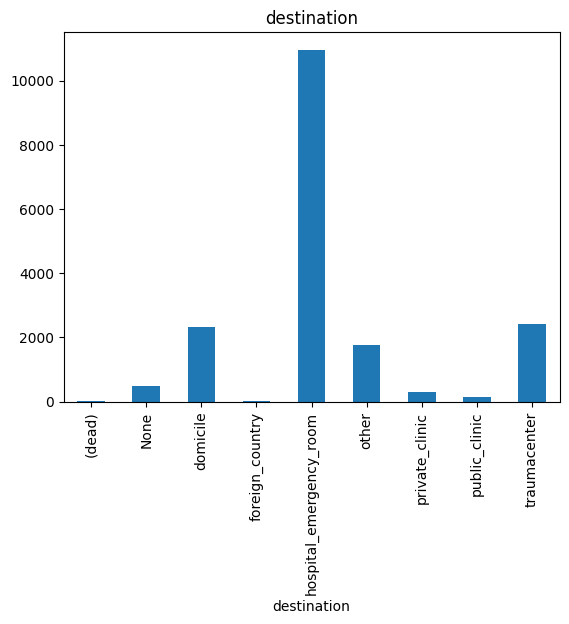

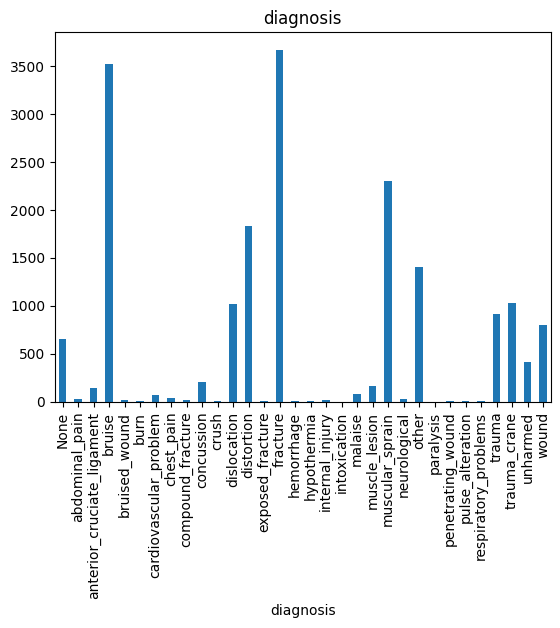

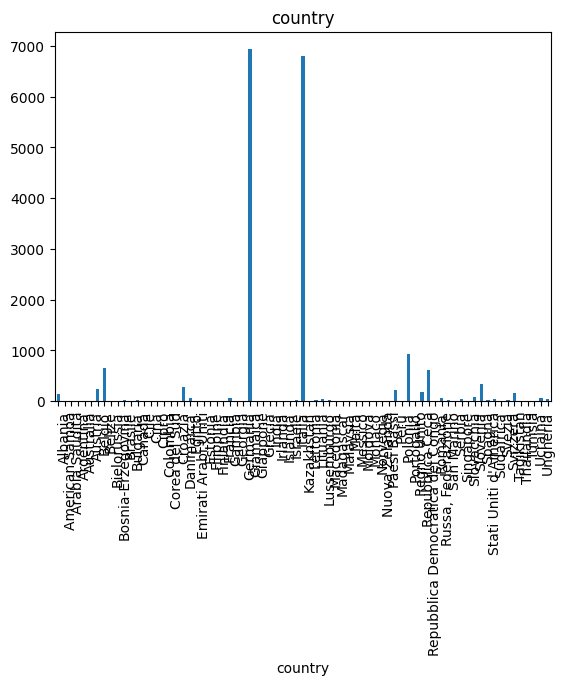

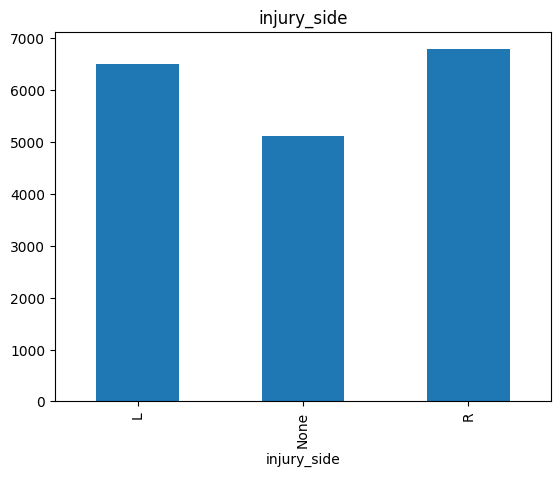

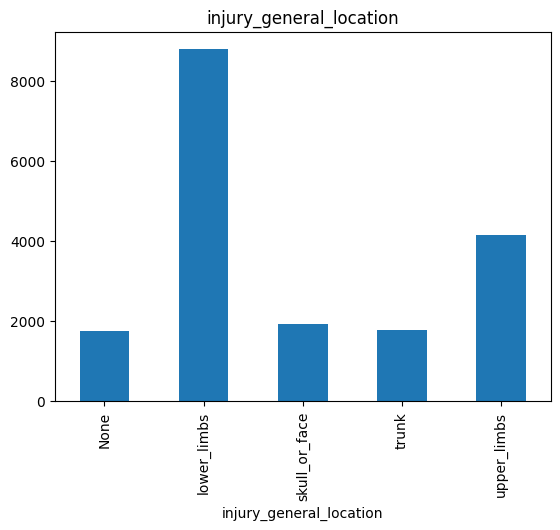

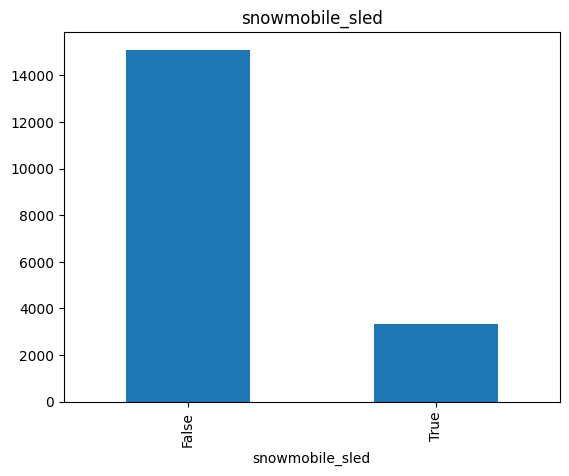

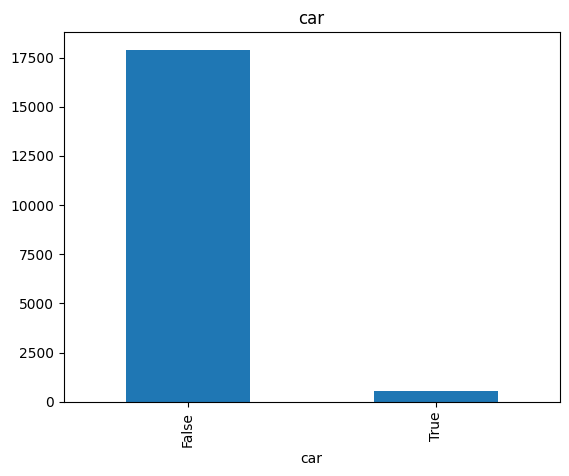

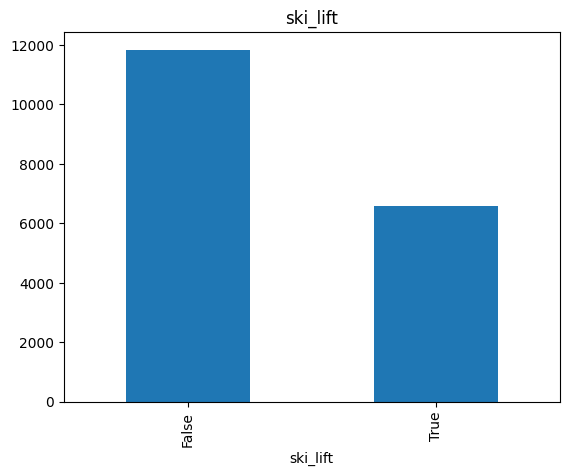

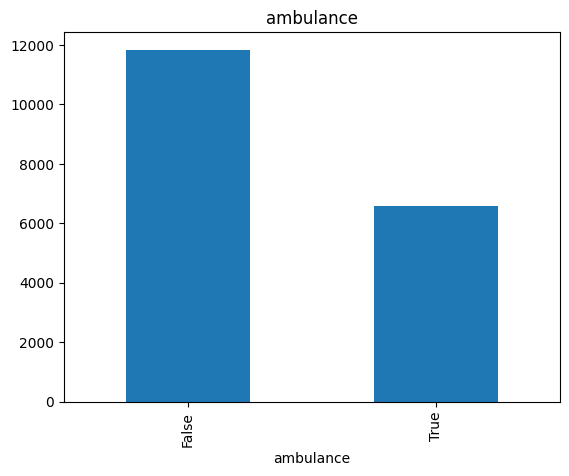

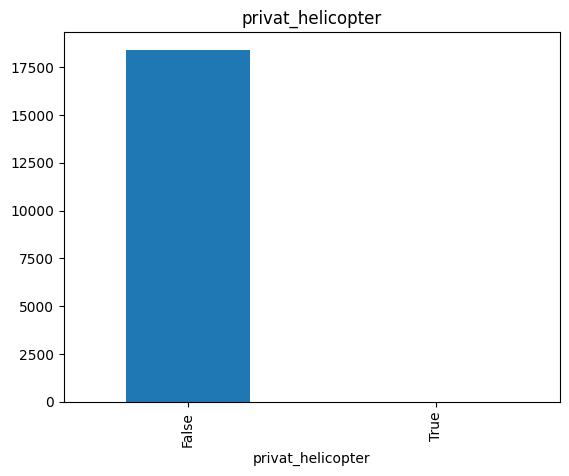

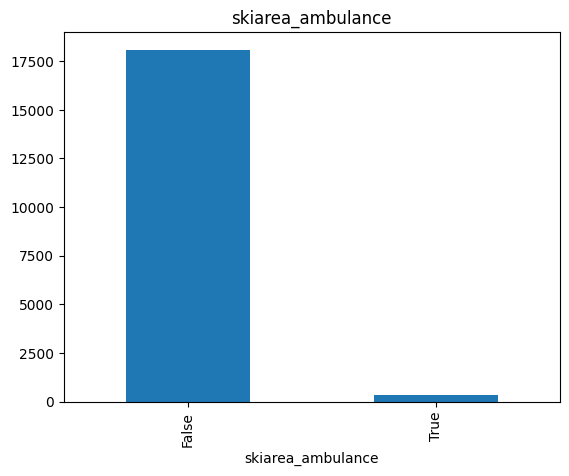

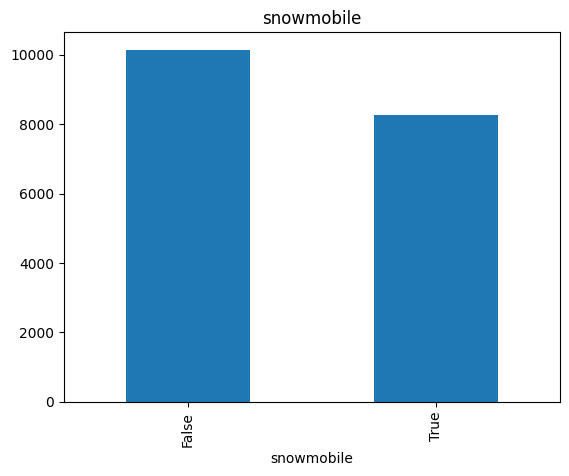

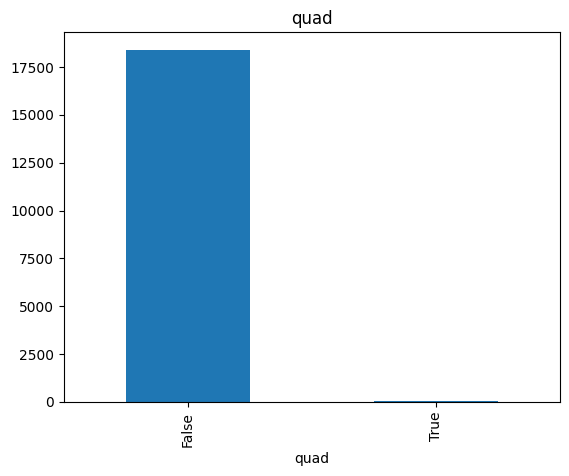

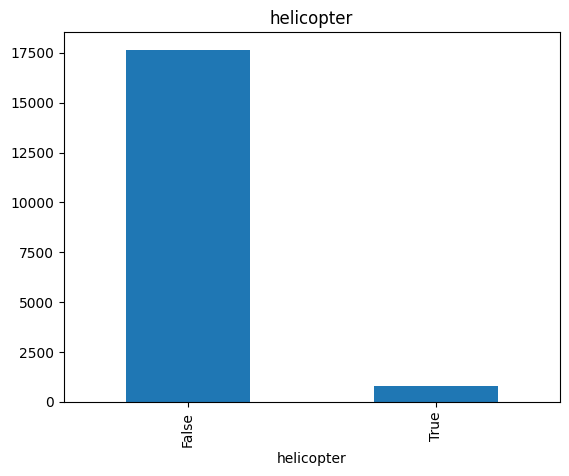

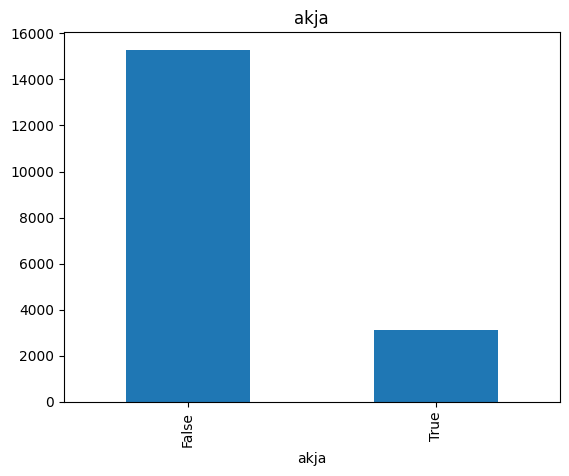

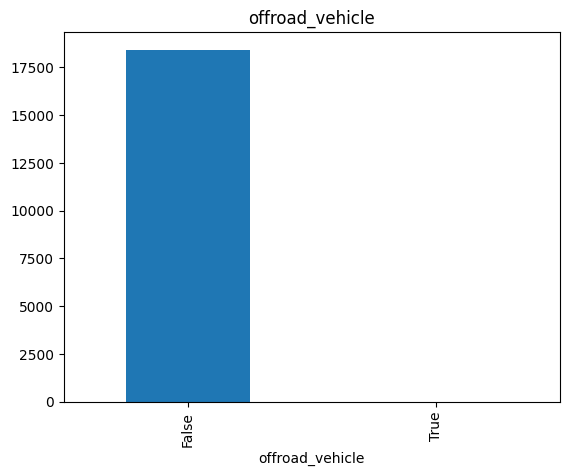

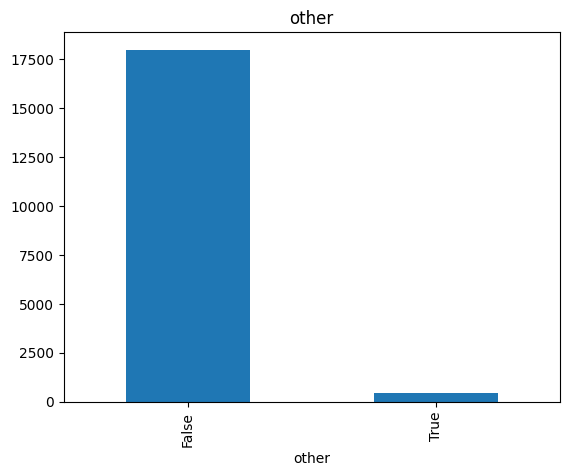

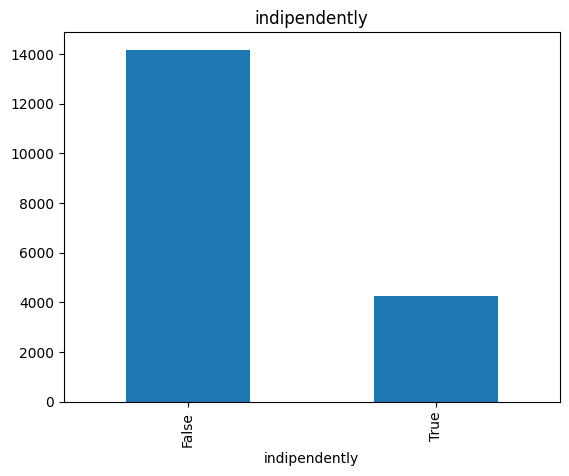

In [8]:
## plot of categorical variables, there are some under-represented categories, 
## maybe it is possible to obtain a more stable model removing such classes
to_remove = {}
TH = 0.5
for c in labeled.columns:
    if c not in ['india','age','season','skiarea_name']:
        labeled[c] = labeled[c].astype('str')  
        plt.figure()
        labeled.groupby(c)[c].count().plot(kind='bar')
        plt.title(c)
        tmp = labeled.groupby(c)[c].count()
        tmp = 100*tmp/tmp.max()
        tmp = tmp[tmp<TH]
        if len(tmp)>0:
            for k in tmp.index:
                if c not in to_remove.keys():
                    to_remove[c]= []
                to_remove[c].append(k)

In [9]:
labeled_small = labeled.copy()
for c in to_remove.keys():
    for k in to_remove[c]:
        labeled_small.loc[labeled_small[c]==k,c] = 'other'
for c in labeled_small.columns:
    if c not in ['age','season','skiarea_name']:
        labeled_small[c] =  labeled_small[c].fillna('None').astype('category')  
        labeled[c] =  labeled[c].fillna('None').astype('category')
labeled.dropna(inplace=True)
labeled_small.dropna(inplace=True)

/tmp/ipykernel_69977/134691014.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  labeled_small.groupby(c)[c].count().plot(kind='bar')
/tmp/ipykernel_69977/134691014.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  labeled_small.groupby(c)[c].count().plot(kind='bar')
/tmp/ipykernel_69977/134691014.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  labeled_small.groupby(c)[c].count().plot(kind='bar')
/tmp/ipykernel_6

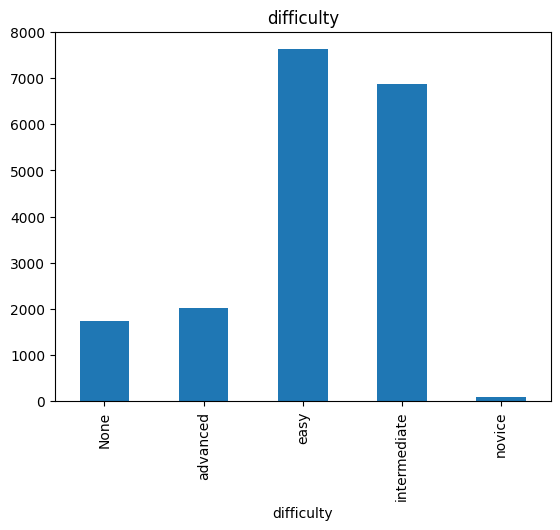

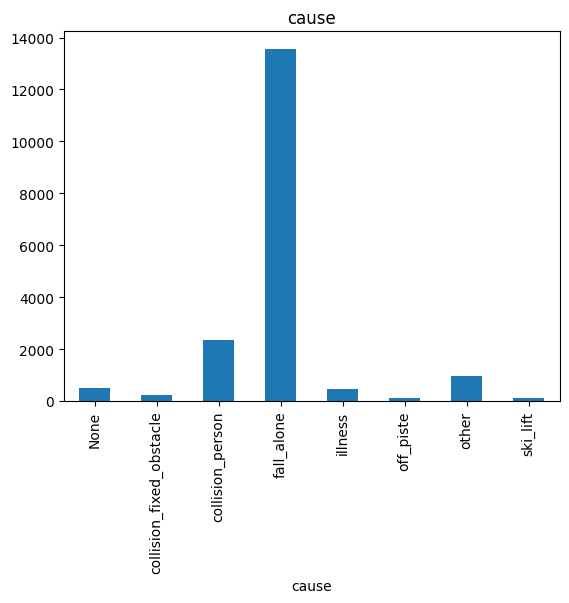

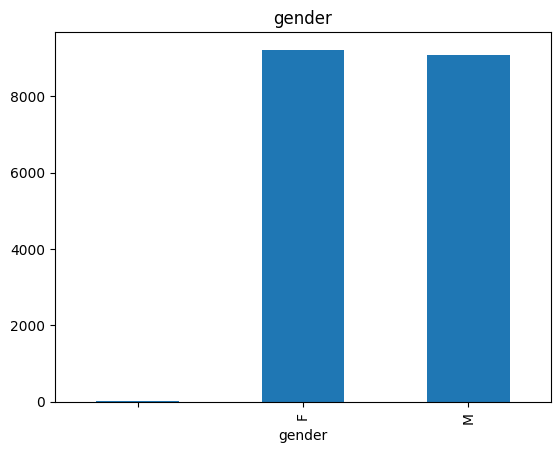

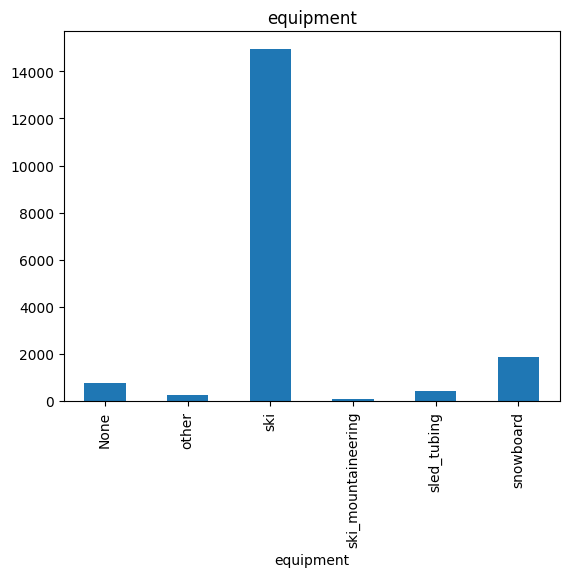

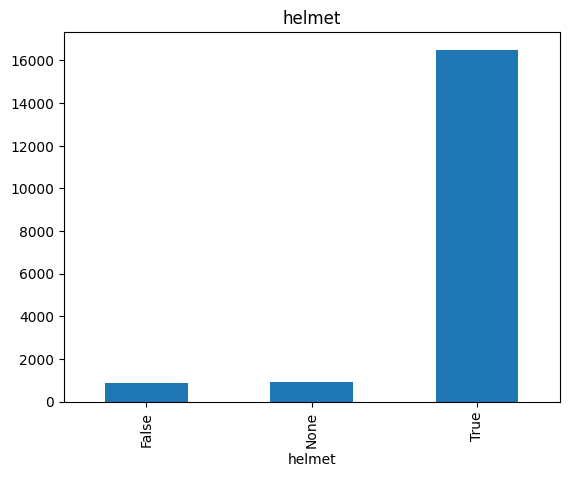

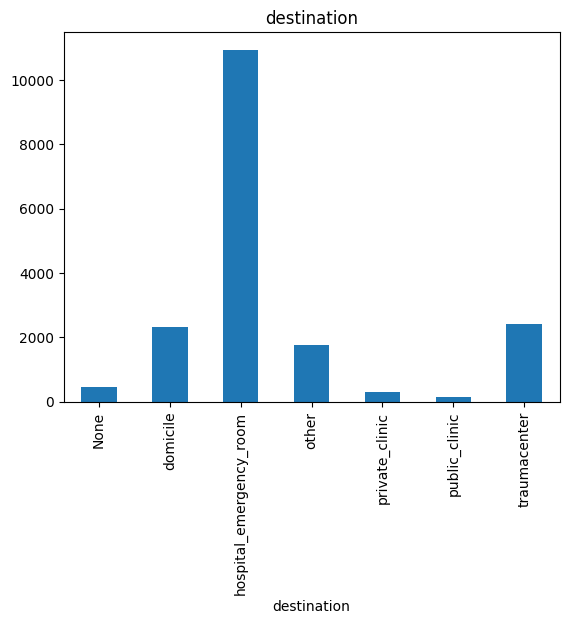

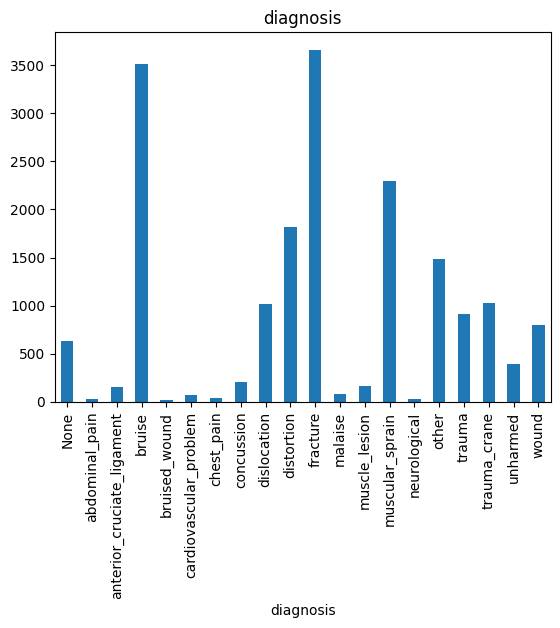

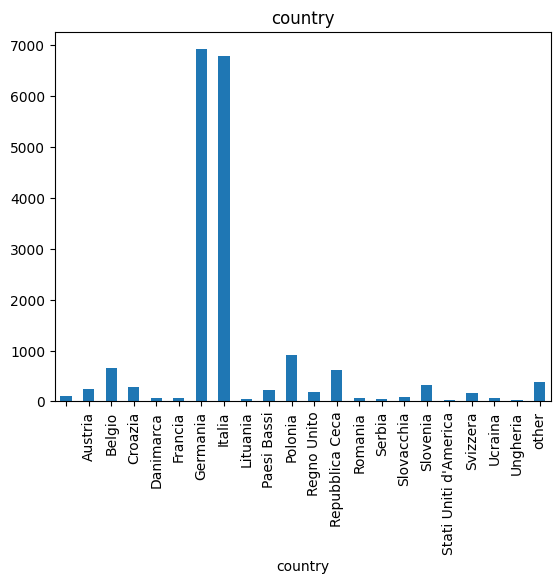

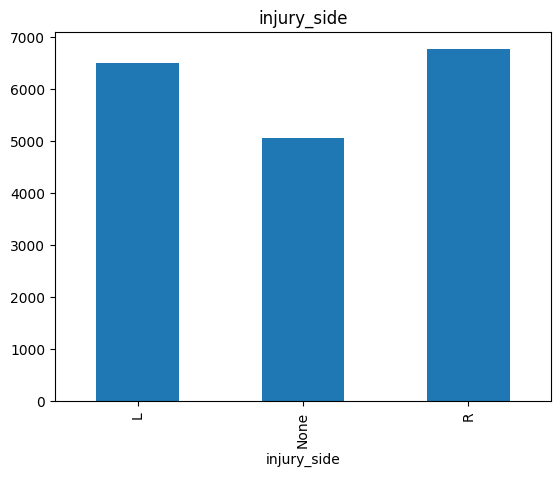

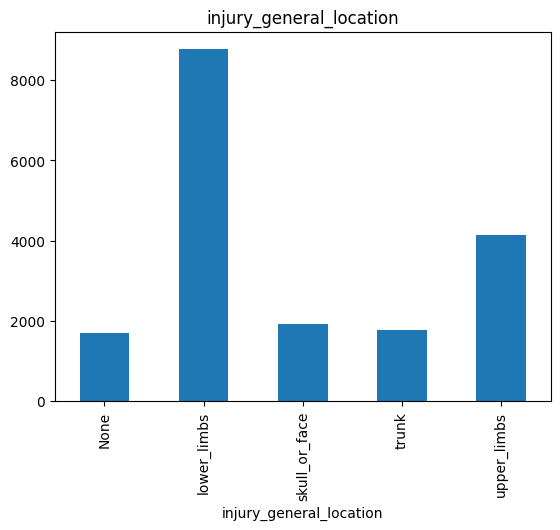

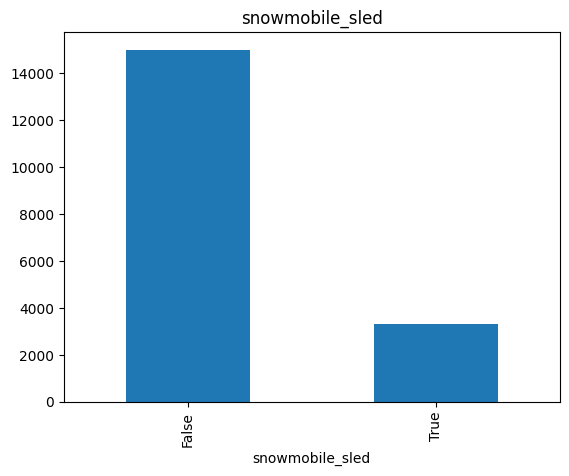

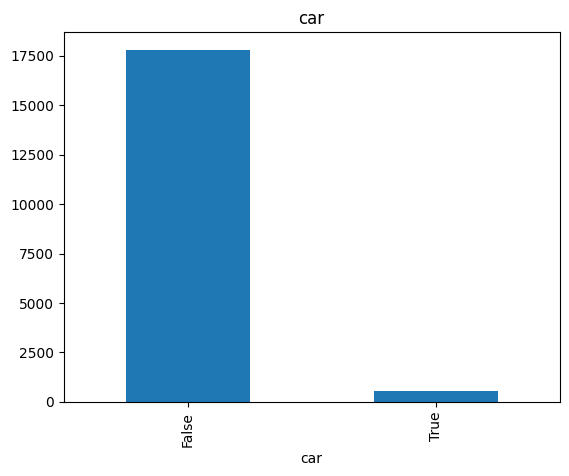

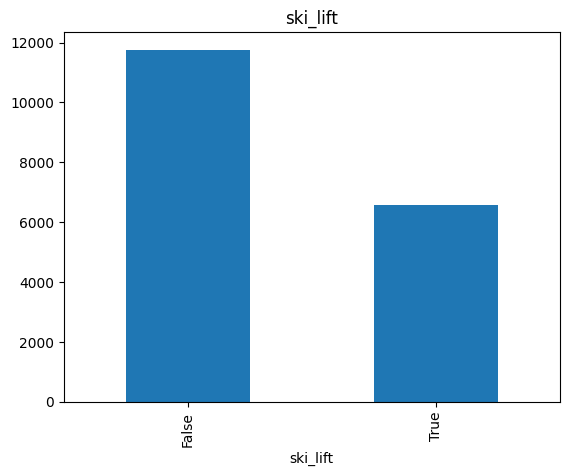

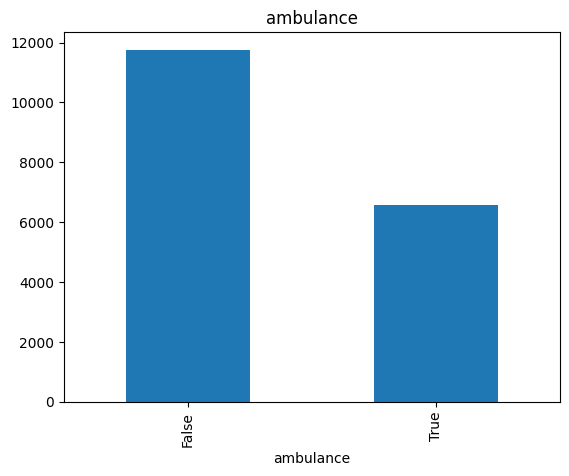

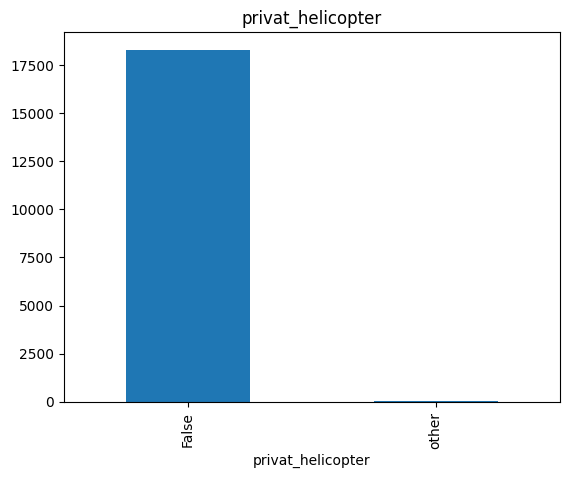

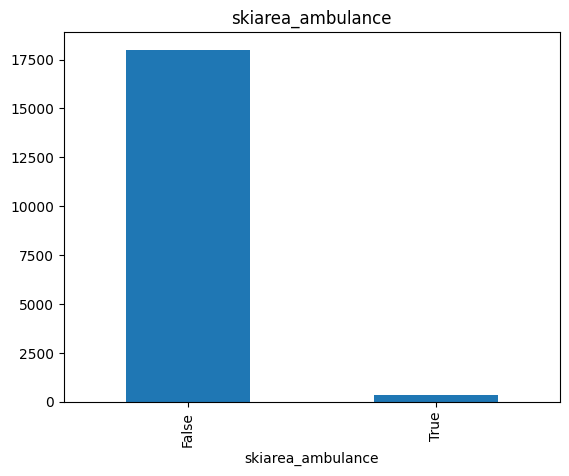

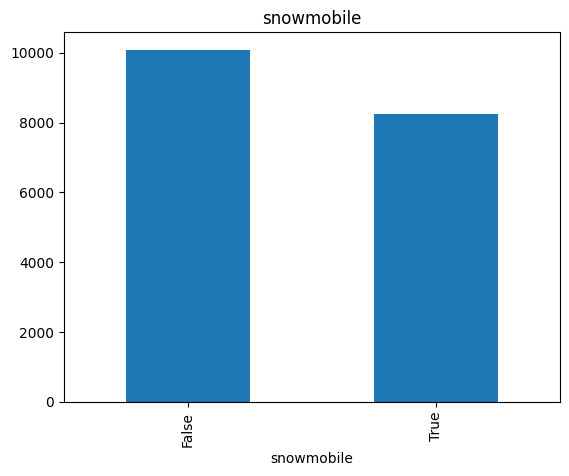

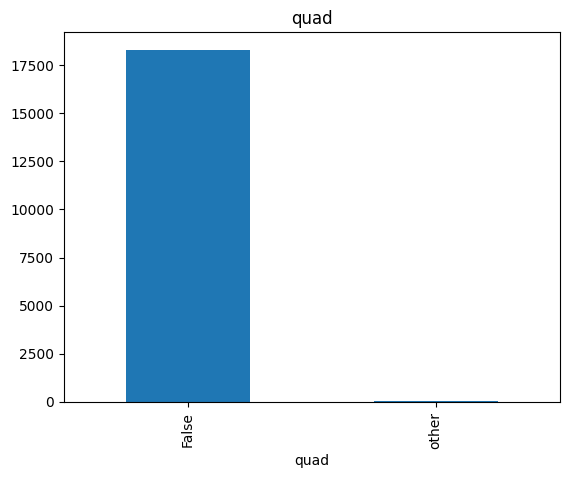

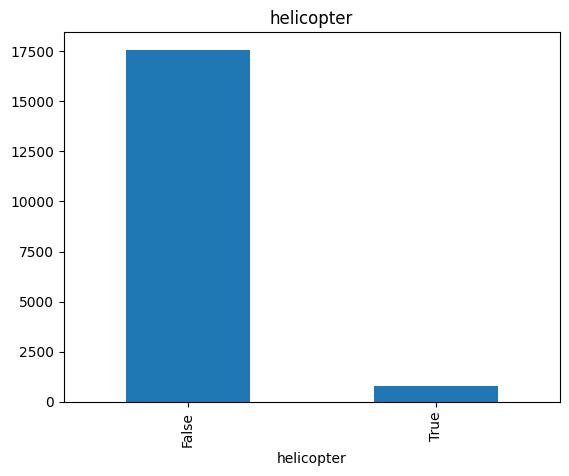

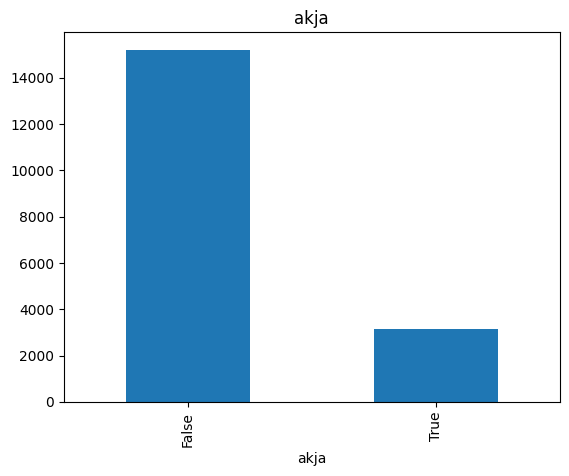

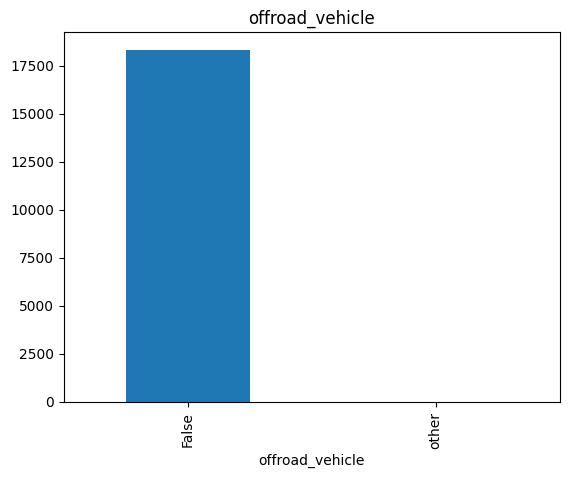

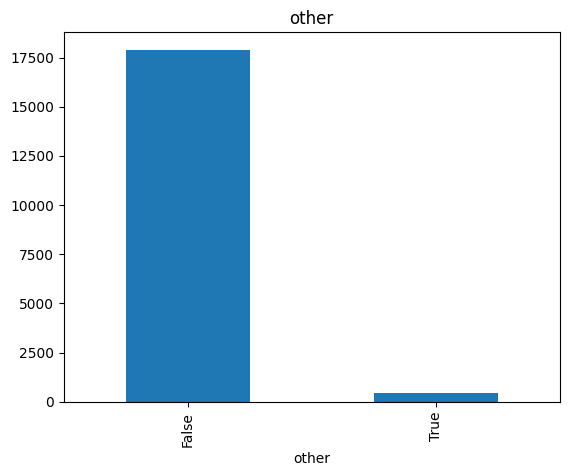

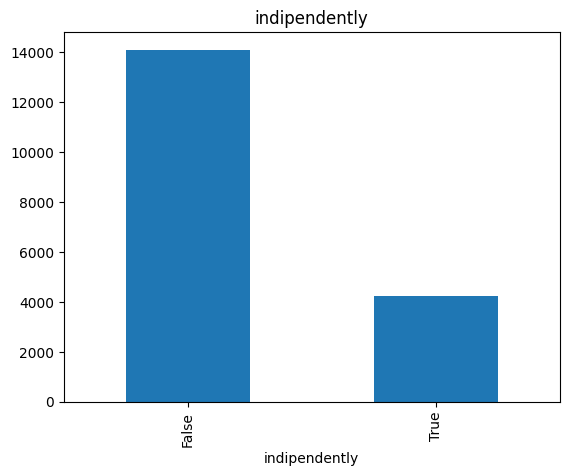

In [10]:
for c in labeled_small.columns:
    if c not in ['india','age','season','skiarea_name']:
        plt.figure()
        labeled_small.groupby(c)[c].count().plot(kind='bar')
        plt.title(c)

    

In [11]:
labeled.head()

skiarea_name  season    difficulty       cause gender equipment helmet  \
0    Kronplatz    2018          None  fall_alone      F       ski   True   
1    Kronplatz    2018          easy     illness      M       ski   True   
2    Kronplatz    2018      advanced  fall_alone      M       ski   True   
3    Kronplatz    2018      advanced  fall_alone      M       ski   True   
4    Kronplatz    2018  intermediate  fall_alone      M       ski   True   

               destination   diagnosis india  ...  ambulance  \
0  hospital_emergency_room  distortion    i1  ...      False   
1                 domicile       other    i0  ...      False   
2  hospital_emergency_room       wound    i1  ...      False   
3  hospital_emergency_room    fracture    i1  ...      False   
4  hospital_emergency_room       other    i1  ...      False   

  privat_helicopter skiarea_ambulance snowmobile   quad helicopter   akja  \
0             False             False       True  False      False  False   
1             False             False      False  False      False  False   
2             False             False      False  False      False   True   
3             False             False      False  False      False   True   
4             False             False      False  False      False   True   

  offroad_vehicle  other indipendently  
0           False  False         False  
1           False  False         False  
2           False  False         False  
3           False  False         False  
4           False  False         False  

[5 rows x 27 columns]

In [21]:
labeled.india = labeled.india.apply(lambda x: x.replace('i','')).astype(int)
labeled_small.india = labeled_small.india.apply(lambda x: x.replace('i','')).astype(int)

In [22]:
##TEST 
SKI_AREA_TEST = 'Klausberg'
SEASON_TEST_SKIAREA = 'Kronplatz'
SEASON_TEST_YEAR = 2023 ##2023-2024
test_area = labeled[labeled.skiarea_name==SKI_AREA_TEST]
test_area_small = labeled_small[labeled_small.skiarea_name==SKI_AREA_TEST]
print(test_area_small.shape)
test_area_season = labeled[(labeled.skiarea_name==SEASON_TEST_SKIAREA)&(labeled.season>=SEASON_TEST_YEAR)]
test_area_season_small = labeled_small[(labeled_small.skiarea_name==SEASON_TEST_SKIAREA)&(labeled_small.season>=SEASON_TEST_YEAR)]
print(test_area_season_small.shape)


(2034, 27)
(2183, 27)


In [23]:

labeled_tmp = labeled[labeled.skiarea_name!=SKI_AREA_TEST]
labeled_tmp = labeled_tmp[(labeled_tmp.skiarea_name!=SEASON_TEST_SKIAREA)|(labeled_tmp.season<SEASON_TEST_YEAR) ]
X_train, X_valid, y_train, y_valid = train_test_split( labeled_tmp.drop(columns=['india','season','skiarea_name']),
                                                    labeled_tmp.india, test_size=0.33, random_state=0,stratify=labeled_tmp.india)

labeled_small_tmp = labeled_small[labeled_small.skiarea_name!=SKI_AREA_TEST]
labeled_small_tmp = labeled_small_tmp[(labeled_small_tmp.skiarea_name!=SEASON_TEST_SKIAREA)|(labeled_small_tmp.season<SEASON_TEST_YEAR) ]
X_train_small, X_valid_small, y_train_small, y_valid_small = train_test_split( labeled_small_tmp.drop(columns=['india','season','skiarea_name']),
                                                    labeled_small_tmp.india, test_size=0.33, random_state=0,stratify=labeled_small_tmp.india)

In [24]:
use_smote = False
if use_smote:
    from imblearn.over_sampling import RandomOverSampler
    
    sm = RandomOverSampler()
    X_train_smote,y_train_smote = sm.fit_resample(X_train,y_train)
    X_train_smote_small,y_train_smote_small = sm.fit_resample(X_train_small,y_train_small)

In [25]:
w = pd.DataFrame(np.unique(y_train,return_counts=True)).T
w.columns = ['class','p']
w.p = np.sqrt(w.p.sum())/w.p
print(w)
weight_train = pd.merge(pd.DataFrame({'class':y_train}),w).p.values


   class          p
0      0   0.203424
1      1   0.013596
2      2   0.056109
3      3   1.130661
4      4  16.206137


In [26]:
##THIS IS BETTER
#w = pd.DataFrame(np.unique(y_train,return_counts=True)).T
#w.columns = ['class','p']
#w.p = w.p.sum()/w.p/w.shape[0]
#print(w)
#weight_train = pd.merge(pd.DataFrame({'class':y_train}),w).p.values
#weight_train

In [58]:
weight_train

array([0.01359575, 0.05610896, 0.01359575, ..., 0.20342432, 0.05610896,
       0.05610896])

In [55]:

def objective(trial,X_train,y_train,X_valid,y_valid,weight_train):
    params = dict(
                learning_rate = trial.suggest_float("learning_rate", 0.01, 0.2),
                max_depth= trial.suggest_int("max_depth",5, 15),
                min_child_weight = trial.suggest_int("min_child_weight", 1, 8),
                gamma = trial.suggest_float("gamma", 0, 10),
                subsample = trial.suggest_float("subsample", 0.01,1),
                colsample_bytree = trial.suggest_float("colsample_bytree", 0.01,1),
                alpha = trial.suggest_float("alpha", 0, 10),
                objective= 'multi:softprob', 
                nthread=4, 
                 num_class= 5,
                seed=27)
    params['lambda'] = trial.suggest_float("lambda", 0, 10)

    
    dtrain = xgb.DMatrix(X_train,y_train, 
                         enable_categorical=True,
                         weight=weight_train)
    dvalid = xgb.DMatrix(X_valid,y_valid,
                         enable_categorical=True,
                         )


    bst = xgb.train(params, dtrain,verbose_eval=False, num_boost_round=600,
                    evals = [(dtrain, "train"), (dvalid, "valid")],
                    early_stopping_rounds=100)

    preds = bst.predict(dvalid)
    ##MCC is more solid
    mcc = matthews_corrcoef(y_valid,preds.argmax(1))    
    
    return mcc



study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: objective(trial,X_train,y_train,X_valid,y_valid,weight_train), n_trials=1000, timeout=600,)

params_final = dict(
            objective= 'multi:softprob', 
            nthread=4, 
             num_class= 5,
            seed=27)
params_final.update(study.best_params)
dtrain = xgb.DMatrix(X_train,y_train, 
                     enable_categorical=True,
                     weight=weight_train)
dvalid = xgb.DMatrix(X_valid,y_valid,
                     enable_categorical=True,
                     )   
bst = xgb.train(params_final, dtrain,verbose_eval=False, num_boost_round=600,
                evals = [(dtrain, "train"), (dvalid, "valid")],
                early_stopping_rounds=100,)


[I 2024-02-19 10:13:34,770] A new study created in memory with name: no-name-eb45f3a5-a8c6-45fe-a5a1-a9a50593fb27
[I 2024-02-19 10:13:35,613] Trial 0 finished with value: 0.1989111911567868 and parameters: {'learning_rate': 0.069550503828446, 'max_depth': 14, 'min_child_weight': 4, 'gamma': 6.840625787856297, 'subsample': 0.6425250659956084, 'colsample_bytree': 0.8479444601860839, 'alpha': 7.62883839298031, 'lambda': 4.463721336424616}. Best is trial 0 with value: 0.1989111911567868.
[I 2024-02-19 10:13:36,882] Trial 1 finished with value: 0.3173094420130114 and parameters: {'learning_rate': 0.03760597869350516, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 4.912637931042977, 'subsample': 0.4614006609002679, 'colsample_bytree': 0.6144190767209258, 'alpha': 1.3722886308582516, 'lambda': 4.119799280632812}. Best is trial 1 with value: 0.3173094420130114.
[I 2024-02-19 10:13:38,133] Trial 2 finished with value: 0.36354566542920486 and parameters: {'learning_rate': 0.029446413231195095,

In [28]:

def objective_small(trial):#,X_train,y_train,X_valid,y_valid,weight_train):
    params = dict(
                #booster = trial.suggest_categorical("booster",['gbtree', 'gblinear', 'dart']),
                learning_rate = trial.suggest_float("learning_rate", 0.01, 0.2),
                max_depth= trial.suggest_int("max_depth",5, 15),
                min_child_weight = trial.suggest_int("min_child_weight", 1, 8),
                gamma = trial.suggest_float("gamma", 0, 10),
                subsample = trial.suggest_float("subsample", 0.01,1),
                colsample_bytree = trial.suggest_float("colsample_bytree", 0.01,1),
                alpha = trial.suggest_float("alpha", 0, 10),
                objective= 'multi:softprob', 
                nthread=4, 
                 num_class= 5,
                seed=27)
    params['lambda'] = trial.suggest_float("lambda", 0, 10)

    
    dtrain = xgb.DMatrix(X_train_small,y_train_small, 
                         enable_categorical=True,
                         weight=weight_train)
    dvalid = xgb.DMatrix(X_valid_small,y_valid_small,
                         enable_categorical=True,
                         )


    bst = xgb.train(params, dtrain,verbose_eval=False, num_boost_round=600,
                    evals = [(dtrain, "train"), (dvalid, "valid")],
                    early_stopping_rounds=100)

    preds = bst.predict(dvalid)
    ##MCC is more solid
    mcc = matthews_corrcoef(y_valid_small,preds.argmax(1))    
    
    return mcc



study_small = optuna.create_study(direction="maximize")
study_small.optimize(objective_small, n_trials=1000, timeout=600)
params_final = dict(
            objective= 'multi:softprob', 
            nthread=4, 
             num_class= 5,
            seed=27)
params_final.update(study_small.best_params)
dtrain_small = xgb.DMatrix(X_train_small,y_train_small, 
                     enable_categorical=True,
                     weight=weight_train)
dvalid_small = xgb.DMatrix(X_valid_small,y_valid_small,
                     enable_categorical=True,
                     )   
bst_small = xgb.train(params_final, dtrain_small,verbose_eval=False, num_boost_round=600,
                evals = [(dtrain_small, "train"), (dvalid_small, "valid")],
                early_stopping_rounds=100,)


[I 2024-02-12 16:16:47,769] A new study created in memory with name: no-name-49cc3e7a-a081-45be-88c6-7bf32f094399
[I 2024-02-12 16:16:47,978] Trial 0 finished with value: 0.0 and parameters: {'learning_rate': 0.05491468823977778, 'max_depth': 8, 'min_child_weight': 1, 'gamma': 7.0040114746112145, 'subsample': 0.04250317969539257, 'colsample_bytree': 0.5947297992544279, 'alpha': 2.5510124618789054, 'lambda': 5.6437883532023765}. Best is trial 0 with value: 0.0.
[I 2024-02-12 16:16:48,793] Trial 1 finished with value: 0.31426941781461487 and parameters: {'learning_rate': 0.1461147252441012, 'max_depth': 8, 'min_child_weight': 1, 'gamma': 9.744462681704128, 'subsample': 0.708376383454642, 'colsample_bytree': 0.771251938342384, 'alpha': 5.398629268029964, 'lambda': 5.948122996822612}. Best is trial 1 with value: 0.31426941781461487.
[I 2024-02-12 16:16:49,607] Trial 2 finished with value: 0.2651178596474042 and parameters: {'learning_rate': 0.021135907717799468, 'max_depth': 7, 'min_child_

In [29]:
if use_smote:
    def objective_small_smote(trial):#,X_train,y_train,X_valid,y_valid,weight_train):
        params = dict(
                    #booster = trial.suggest_categorical("booster",['gbtree', 'gblinear', 'dart']),
                    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.2),
                    max_depth= trial.suggest_int("max_depth",5, 15),
                    min_child_weight = trial.suggest_int("min_child_weight", 1, 8),
                    gamma = trial.suggest_float("gamma", 0, 10),
                    subsample = trial.suggest_float("subsample", 0.01,1),
                    colsample_bytree = trial.suggest_float("colsample_bytree", 0.01,1),
                    alpha = trial.suggest_float("alpha", 0, 10),
                    objective= 'multi:softprob', 
                    nthread=4, 
                     num_class= 5,
                    seed=27)
        params['lambda'] = trial.suggest_float("lambda", 0, 10)
    
        
        dtrain = xgb.DMatrix(X_train_smote_small,y_train_smote_small, 
                             enable_categorical=True,)
        dvalid = xgb.DMatrix(X_valid_small,y_valid_small,
                             enable_categorical=True,
                             )
    
    
        bst = xgb.train(params, dtrain,verbose_eval=False, num_boost_round=400,
                        evals = [(dtrain, "train"), (dvalid, "valid")],
                        early_stopping_rounds=100)
    
        preds = bst.predict(dvalid)
        ##MCC is more solid
        mcc = matthews_corrcoef(y_valid_small,preds.argmax(1))    
        
        return mcc
    
    
    
    study_small = optuna.create_study(direction="maximize")
    study_small.optimize(objective_small, n_trials=200, timeout=600)
    params_final = dict(
                objective= 'multi:softprob', 
                nthread=4, 
                 num_class= 5,
                seed=27)
    params_final.update(study_small.best_params)
    dtrain_small = xgb.DMatrix(X_train_smote_small,y_train_smote_small, 
                         enable_categorical=True,
                      )
    dvalid_small = xgb.DMatrix(X_valid_small,y_valid_small,
                         enable_categorical=True,
                         )   
    bst_small = xgb.train(params_final, dtrain_small,verbose_eval=False, num_boost_round=400,
                    evals = [(dtrain_small, "train"), (dvalid_small, "valid")],
                    early_stopping_rounds=100,)


Text(0, 0.5, 'Feature Importance Score')

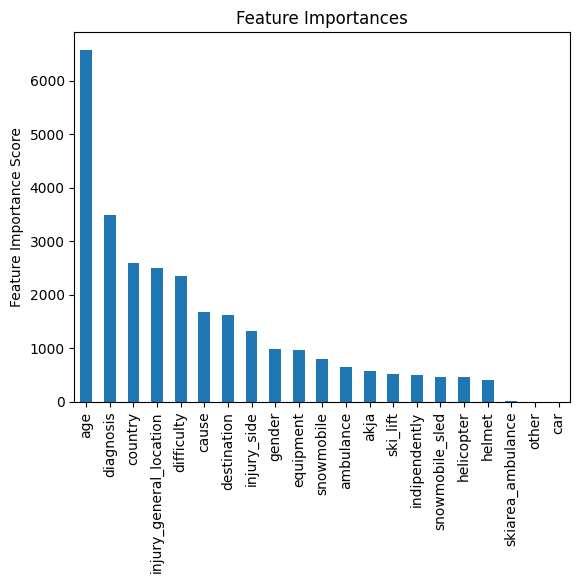

In [30]:
feat_imp = pd.Series(bst_small.get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

In [32]:
preds_class_valid = bst.predict(dvalid)
preds_class_train= bst.predict(dtrain)
print(confusion_matrix(y_valid,preds_class_valid.argmax(1)))
print(matthews_corrcoef(y_valid,preds_class_valid.argmax(1)))
print(accuracy_score(y_valid,preds_class_valid.argmax(1)))
print('########################################')
print(confusion_matrix(y_train,preds_class_train.argmax(1)))
print(matthews_corrcoef(y_train,preds_class_train.argmax(1)))
print(accuracy_score(y_train,preds_class_train.argmax(1)))

[[ 206   29    1    0    0]
 [ 224 2572  717   11    0]
 [  10  192  595   55    1]
 [   2    2   22   16    0]
 [   2    0    0    0    1]]
0.4669354220226053
0.7277801631601546
########################################
[[ 461   14    3    0    0]
 [ 433 5275 1408   36    0]
 [  10  251 1392   80    0]
 [   0    0    0   86    0]
 [   0    0    0    0    6]]
0.5578338794431741
0.7636171337916446


In [ ]:
if use_smote:
    preds_class_valid = bst_small.predict(dvalid_small)
    preds_class_train= bst_small.predict(dtrain_small)
    print(confusion_matrix(y_valid_small,preds_class_valid.argmax(1)))
    print(matthews_corrcoef(y_valid_small,preds_class_valid.argmax(1)))
    print(accuracy_score(y_valid_small,preds_class_valid.argmax(1)))
    print('########################################')
    print(confusion_matrix(y_train_smote_small,preds_class_train.argmax(1)))
    print(matthews_corrcoef(y_train_smote_small,preds_class_train.argmax(1)))
    print(accuracy_score(y_train_smote_small,preds_class_train.argmax(1)))

In [33]:

preds_class_valid = bst_small.predict(dvalid_small)
preds_class_train= bst_small.predict(dtrain_small)
print(confusion_matrix(y_valid_small,preds_class_valid.argmax(1)))
print(matthews_corrcoef(y_valid_small,preds_class_valid.argmax(1)))
print(accuracy_score(y_valid_small,preds_class_valid.argmax(1)))
print('########################################')
print(confusion_matrix(y_train_small,preds_class_train.argmax(1)))
print(matthews_corrcoef(y_train_small,preds_class_train.argmax(1)))
print(accuracy_score(y_train_small,preds_class_train.argmax(1)))

[[ 191   42    2    0    1]
 [ 161 2702  641   12    8]
 [   7  226  571   47    2]
 [   2    2   29    9    0]
 [   2    1    0    0    0]]
0.4671584355563095
0.7455989695148132
########################################
[[ 474    2    1    0    1]
 [ 261 5744 1115   28    4]
 [   3  188 1504   37    1]
 [   0    0    0   86    0]
 [   0    0    0    0    6]]
0.6559067720290881
0.8264410364886303


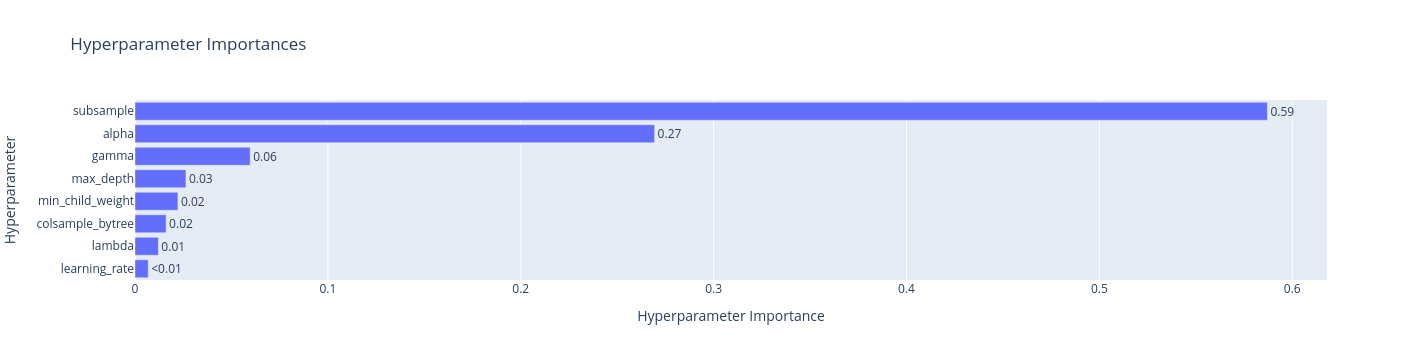

In [34]:
from optuna.visualization import plot_param_importances,plot_edf,plot_optimization_history
#plot_edf(study)
#plot_optimization_history(study)

plot_param_importances(study_small)

In [189]:
params_final

{'objective': 'multi:softprob',
 'nthread': 4,
 'num_class': 5,
 'seed': 27,
 'learning_rate': 0.06267938904293768,
 'max_depth': 14,
 'min_child_weight': 7,
 'gamma': 0.6199971726667972,
 'subsample': 0.8015724244693958,
 'colsample_bytree': 0.5064972828251288,
 'alpha': 0.11096589649454103,
 'lambda': 0.5753594958776281}

In [35]:
## me li salvo altrimenti ogni volta e' un casino
with open('best_params.pkl','wb') as f:
    pickle.dump([params_final,feat_imp],f)

In [36]:
with open('best_params.pkl','rb') as f:
    params_final,feat_imp = pickle.load(f)

In [37]:
## sklearn interface

In [38]:
tot = []
use_smote = False

for i in range(1,X_train_small.shape[1]):
    if use_smote:
        dtrain_small_FS = xgb.DMatrix(X_train_smote_small[list(feat_imp.head(i).index)],y_train_smote_small, 
                             enable_categorical=True,)
                             #weight=weight_train)
    else:
        dtrain_small_FS = xgb.DMatrix(X_train_small[list(feat_imp.head(i).index)],y_train_small, 
                             enable_categorical=True,
                             weight=weight_train)
    dvalid_small_FS = xgb.DMatrix(X_valid_small[list(feat_imp.head(i).index)],y_valid_small, enable_categorical=True,)
   
    bst_small_FS = xgb.train(params_final, dtrain_small_FS,verbose_eval=False, num_boost_round=600,
                             evals = [(dtrain_small_FS, "train"), (dvalid_small_FS, "valid")],
                             early_stopping_rounds=100,)
    preds_class_valid = bst_small_FS.predict(dvalid_small_FS)
    mcc = matthews_corrcoef(y_valid_small,preds_class_valid.argmax(1))
    acc = accuracy_score(y_valid_small,preds_class_valid.argmax(1))
    tot.append({'mcc':mcc,'acc':acc,'FS':i})

In [41]:
tot = pd.DataFrame(tot)
tot

mcc       acc  FS
0   0.024347  0.256763   1
1   0.303988  0.585659   2
2   0.324149  0.614856   3
3   0.374640  0.672821   4
4   0.394719  0.687419   5
5   0.399983  0.695578   6
6   0.431865  0.709532   7
7   0.430755  0.710176   8
8   0.430538  0.710176   9
9   0.434400  0.715758  10
10  0.429238  0.713826  11
11  0.430244  0.717046  12
12  0.435320  0.720481  13
13  0.444619  0.728210  14
14  0.451718  0.733577  15
15  0.449903  0.731000  16
16  0.467224  0.745170  17
17  0.461310  0.742164  18
18  0.466519  0.745814  19
19  0.465960  0.745170  20
20  0.468924  0.745599  21
21  0.468924  0.745599  22
22  0.468924  0.745599  23

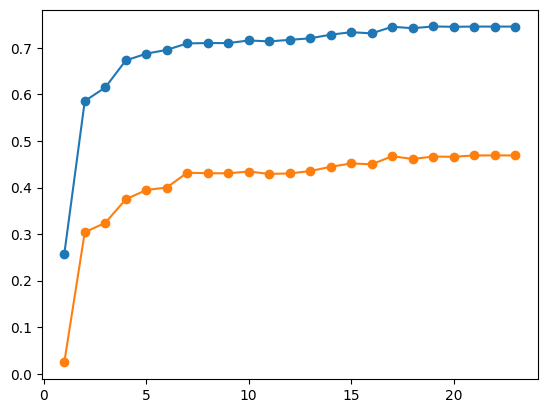

In [42]:
plt.plot(tot.FS,tot.acc,'o-',label='accuracy')
plt.plot(tot.FS,tot.mcc,'o-',label='MCC')

In [43]:
FS = int(tot.loc[tot.acc.argmax()].FS)
FS

19

In [44]:
test_area = labeled[labeled.skiarea_name==SKI_AREA_TEST]
test_area_small = labeled_small[labeled_small.skiarea_name==SKI_AREA_TEST]

test_area_season = labeled[(labeled.skiarea_name==SEASON_TEST_SKIAREA)&(labeled.season>=SEASON_TEST_YEAR)]
test_area_season_small = labeled_small[(labeled_small.skiarea_name==SEASON_TEST_SKIAREA)&(labeled_small.season>=SEASON_TEST_YEAR)]


In [46]:

if use_smote:
    dtrain_small_FS = xgb.DMatrix(X_train_smote_small[list(feat_imp.head(FS).index)],y_train_smote_small, 
                         enable_categorical=True,)
                        # weight=weight_train)
else:
    dtrain_small_FS = xgb.DMatrix(X_train_small[list(feat_imp.head(FS).index)],y_train_small, 
                         enable_categorical=True,
                         weight=weight_train)
dvalid_small_FS = xgb.DMatrix(X_valid_small[list(feat_imp.head(FS).index)],y_valid_small,
                     enable_categorical=True,
                     )


bst_small_FS = xgb.train(params_final, dtrain_small_FS,verbose_eval=False, num_boost_round=600,
                evals = [(dtrain_small_FS, "train"), (dvalid_small_FS, "valid")],
                early_stopping_rounds=100,)
dtest_small_FS = xgb.DMatrix(test_area_small[list(feat_imp.head(FS).index)],test_area_small.india,
                     enable_categorical=True,
                     )
dtest_season_small_FS = xgb.DMatrix(test_area_season_small[list(feat_imp.head(FS).index)],test_area_season_small.india,
                     enable_categorical=True,
                     )
preds_class_test = bst_small_FS.predict(dtest_small_FS)
preds_class_test_season = bst_small_FS.predict(dtest_season_small_FS)

mcc = matthews_corrcoef(test_area_small.india,preds_class_test.argmax(1))
acc = accuracy_score(test_area_small.india,preds_class_test.argmax(1))
cm = confusion_matrix(test_area_small.india,preds_class_test.argmax(1))

print(f'{mcc=}, {acc=}, \n{cm=}')
mcc = matthews_corrcoef(test_area_season_small.india,preds_class_test_season.argmax(1))
acc = accuracy_score(test_area_season_small.india,preds_class_test_season.argmax(1))
cm = confusion_matrix(test_area_season_small.india,preds_class_test_season.argmax(1))

print(f'{mcc=}, {acc=}, {cm=}')


mcc=0.3789808968443661, acc=0.7517207472959685, 
cm=array([[  39,   27,    1,    0,    0],
       [  45, 1275,  235,    1,    1],
       [   1,  175,  213,    7,    0],
       [   0,    0,   11,    2,    0],
       [   0,    0,    1,    0,    0]])
mcc=0.4520291259107882, acc=0.7425561154374714, cm=array([[  53,   14,    2,    0,    0],
       [  34, 1259,  369,    2,    2],
       [   0,  107,  306,   21,    0],
       [   0,    0,   11,    2,    0],
       [   0,    0,    0,    0,    1]])


In [96]:
test_area_small

Empty DataFrame
Columns: [skiarea_name, season, difficulty, cause, gender, equipment, helmet, destination, diagnosis, india, age, country, injury_side, injury_general_location, offroad_vehicle, quad, privat_helicopter, car, ski_lift, akja, other, indipendently, snowmobile, snowmobile_sled, ambulance, skiarea_ambulance, helicopter]
Index: []

[0 rows x 27 columns]

In [51]:
X_train_small.shape

(9455, 24)

In [53]:
X_valid_small.shape

(4658, 24)